In [1]:
import pandas as pd
import geopandas as gpd
import psycopg2
from matplotlib import pyplot as plt
from shapely.geometry import Point
%matplotlib inline

## Prepare the input file for ClimateWNA

In [2]:
pg_engine='postgresql://postgres@localhost:5432/PNWFIADB_FVSIn'
SQL = '''
SELECT 
plot.cn AS id1, NULL as id2, 
plot.lat as lat, 
plot.lon as lon,
plot.elev*0.3048 as el
FROM plot, subplot, tree
WHERE plot.cn = tree.plt_cn AND subplot.plt_cn = plot.cn AND
tree.subp = subplot.subp AND tree.spcd = 202 AND 
tree.dia IS NOT NULL AND tree.cr IS NOT NULL AND
tree.inc10yr_pnwrs IS NOT NULL AND subplot.slope IS NOT NULL AND
subplot.aspect IS NOT NULL
GROUP BY id1, id2, lat, lon, el
'''
# read in the stands from the FVSIn database
locations = pd.read_sql(sql=SQL, con=pg_engine)
locations.head()

,id1,id2,lat,lon,el
0,10775507020004,None,43.045378,-123.905345,457.20
1,12393556010497,None,41.634495,-123.785779,518.16
2,12778284010497,None,45.251447,-118.964179,1249.68
3,12778644010497,None,45.455118,-118.277455,1005.84
4,12778871010497,None,45.540632,-118.474862,1188.72


In [3]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14025 entries, 0 to 14024
Data columns (total 5 columns):
id1    14025 non-null object
id2    0 non-null object
lat    14025 non-null float64
lon    14025 non-null float64
el     14025 non-null float64
dtypes: float64(3), object(2)
memory usage: 547.9+ KB


In [4]:
locations.to_csv('PNWFIA_DF_plots.csv', index=False)

In [5]:
SQL = '''
SELECT MIN(inv_year), MAX(inv_year)
FROM fvs_standinit
'''
# read in the stands from the FVSIn database
year_ranges = pd.read_sql(sql=SQL, con=pg_engine)
year_ranges

,min,max
0,1999,2016


## Visualize a map of our plot locations

In [5]:
# read in the FVS variants
fvs_variants = gpd.read_file('FVS_Variants_and_Locations.shp')

# now lets turn those FIA location points into a geodataframe to get the
# correspondong FVS regional variants and location codes
geometry = [Point(xy) for xy in zip(locations.lon, locations.lat)]
locations = locations.drop(['lon', 'lat'], axis=1)
FIA_locs = gpd.GeoDataFrame(locations, crs={'init': 'epsg:4326'}, geometry=geometry)
FIA_locs = FIA_locs.to_crs(fvs_variants.crs)

# let's gather the major west coast variants (OR, WA, and CA)
variants = ['WC', 'PN', 'EC', 'BM', 'SO', 'CA', 'NC', 'CA', 'WS']
west_coast = fvs_variants.loc[fvs_variants.FVSVariant.isin(variants)]

# grab the row index values for the additional locations we want
# from the other variants
more_locs = [1, 200, 240, 46, 92, 110]

# concatenate the extra locations and the major west coast variants
my_locations = pd.concat([fvs_variants.iloc[more_locs],west_coast])
my_variants = my_locations.dissolve(by='FVSVariant').reset_index()

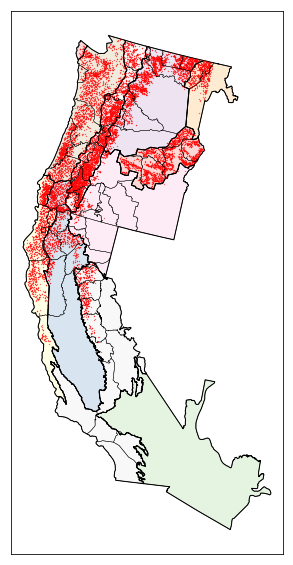

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
# color by FVS Regional Varian
my_variants.plot(ax = ax, column='FVSVariant', linewidth=1, cmap='Pastel1', edgecolor='black')
FIA_locs.plot(ax = ax, marker='o', color='red', markersize=0.25)
my_locations.plot(ax=ax, linewidth=0.4, facecolor='none', edgecolor='black')
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False);

In [13]:
fig.savefig('DF_plots.png')